In [1]:
import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
from keras.wrappers.scikit_learn import KerasClassifier
from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

SR = 16000
blocksize = int(SR)
overlap = int(SR/2)

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
audio_dir = '../ESC-50/audio/'

In [5]:
path_to_db='../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50

In [7]:
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {'dog': 0,'rooster': 0,'pig': 0,'cow': 0,'frog': 0,'cat': 0,'hen': 0,
            'insects': 0,'sheep': 0,'crow': 0,'rain': 1,'sea_waves': 1,'crackling_fire': 1,
            'crickets': 0,'chirping_birds': 0,'water_drops': 1,'wind': 1,'pouring_water': 1,
            'toilet_flush': 1,'thunderstorm': 1,'crying_baby': 0,'sneezing': 0,'clapping': 0,
            'breathing': 0,'coughing': 0,'footsteps': 1,'laughing': 0,'brushing_teeth': 1,
            'snoring': 0,'drinking_sipping': 1,'door_wood_knock': 1,'mouse_click': 1,
            'keyboard_typing': 1,'door_wood_creaks': 1,'can_opening': 1,'washing_machine': 1,
            'vacuum_cleaner': 1,'clock_alarm': 1,'clock_tick': 1,'glass_breaking':1,'helicopter': 1,
            'chainsaw': 1,'siren': 1,'car_horn': 1,'engine': 1,'train': 1,'church_bells': 1,
            'airplane': 1,'fireworks': 1,'hand_saw': 1,
            }

In [8]:
dataset['h_target'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_target'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_target
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [10]:
df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        fld=range(1,5),
                        blocksize=blocksize, 
                        overlap=overlap)

Preprocess file not found, building new one
Epoch 1/1
2/2 [==============================] - 0s 71ms/step - loss: 1.3378
	Bytes: 64080
	Processing Time: 350.02630043029785


In [11]:
df = ps.bag_of_features(df)

In [12]:
df.describe()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_mean,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target
count,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,...,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000,1600.000000
mean,68.392176,41.626128,34.414113,29.584520,26.704804,26.403885,26.030799,25.986042,25.584837,25.071507,...,-0.023051,-0.027111,-0.025023,15.921645,28.230562,5.957012,25.264967,4.442260,0.620000,24.500000
std,26.503678,15.683141,16.213026,14.748283,14.982433,15.462390,15.502125,16.015013,16.049969,15.645559,...,0.058492,0.063429,0.060124,8.000755,12.302128,3.587324,13.066003,2.625496,0.485538,14.435381
min,2.765703,2.219900,1.925966,1.607934,1.037395,1.379451,1.220553,1.246647,1.325921,1.247453,...,-0.295605,-0.401249,-0.356166,5.815685,11.600177,1.946171,9.726162,0.533410,0.000000,0.000000
25%,46.908604,29.867657,20.699574,16.005048,12.305186,11.513304,11.091351,10.398829,10.122304,9.556914,...,-0.058599,-0.065608,-0.061466,10.670691,20.339672,3.870926,16.950437,2.495087,0.000000,12.000000
50%,67.472404,41.097861,32.082370,27.808841,25.057627,24.004113,24.603462,24.603316,24.236682,24.490926,...,-0.021384,-0.020390,-0.019264,13.862573,24.801168,4.987959,21.800416,4.163241,1.000000,24.500000
75%,87.370475,52.330421,46.148207,41.723490,40.095945,40.549712,40.420141,40.441647,39.880189,39.417506,...,0.014911,0.015624,0.014708,18.957784,33.510561,7.032860,29.323586,5.806976,1.000000,37.000000
max,152.990931,94.887900,92.678212,76.212504,75.001668,76.185901,84.761325,94.589380,106.607614,105.094272,...,0.166657,0.162462,0.210591,104.656613,187.004716,57.626973,180.179270,24.324563,1.000000,49.000000


In [13]:
from sklearn.model_selection import train_test_split
train, test, = train_test_split(
                        df, test_size=0.20, random_state=42)

In [14]:
train_X = train.drop(['target', 'h_target'], axis=1)
train_y = train['h_target']
test_X = test.drop(['target', 'h_target'], axis=1)
test_y = test['h_target']

# Shallow Net
Separate into classes

In [15]:
from keras.layers import Dense, Dropout
from keras.models import Sequential

def gpu_mfcc_deep_net_a():
    # Create Model
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(129,)))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    model.summary()

    
    return model

In [16]:
anim = KerasClassifier(build_fn=gpu_mfcc_deep_net_a, 
                       epochs=200, 
                       batch_size=128, 
                       validation_split=0.15)
history = anim.fit(train_X, train_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 10,945
Trainable params: 10,945
Non-trainable params: 0
_________________________________________________________________
Train on 1088 samples, validate on 192 samples
Epoch 1/200
1088/1088 [==============================] - 1s 466us/step - loss: 5.9344 - acc

1088/1088 [==============================] - 0s 29us/step - loss: 5.9344 - acc: 0.6278 - val_loss: 5.8123 - val_acc: 0.6354
Epoch 54/200
1088/1088 [==============================] - 0s 29us/step - loss: 5.9344 - acc: 0.6278 - val_loss: 5.8123 - val_acc: 0.6354
Epoch 55/200
1088/1088 [==============================] - 0s 27us/step - loss: 5.9344 - acc: 0.6278 - val_loss: 5.8123 - val_acc: 0.6354
Epoch 56/200
1088/1088 [==============================] - 0s 29us/step - loss: 5.9344 - acc: 0.6278 - val_loss: 5.8123 - val_acc: 0.6354
Epoch 57/200
1088/1088 [==============================] - 0s 28us/step - loss: 5.9344 - acc: 0.6278 - val_loss: 5.8123 - val_acc: 0.6354
Epoch 58/200
1088/1088 [==============================] - 0s 30us/step - loss: 5.9344 - acc: 0.6278 - val_loss: 5.8123 - val_acc: 0.6354
Epoch 59/200
1088/1088 [==============================] - 0s 26us/step - loss: 5.9344 - acc: 0.6278 - val_loss: 5.8123 - val_acc: 0.6354
Epoch 60/200
1088/1088 [==============================

Epoch 113/200
1088/1088 [==============================] - 0s 28us/step - loss: 5.9344 - acc: 0.6278 - val_loss: 5.8123 - val_acc: 0.6354
Epoch 114/200
1088/1088 [==============================] - 0s 27us/step - loss: 5.9344 - acc: 0.6278 - val_loss: 5.8123 - val_acc: 0.6354
Epoch 115/200
1088/1088 [==============================] - 0s 27us/step - loss: 5.9344 - acc: 0.6278 - val_loss: 5.8123 - val_acc: 0.6354
Epoch 116/200
1088/1088 [==============================] - 0s 29us/step - loss: 5.9344 - acc: 0.6278 - val_loss: 5.8123 - val_acc: 0.6354
Epoch 117/200
1088/1088 [==============================] - 0s 29us/step - loss: 5.9344 - acc: 0.6278 - val_loss: 5.8123 - val_acc: 0.6354
Epoch 118/200
1088/1088 [==============================] - 0s 27us/step - loss: 5.9344 - acc: 0.6278 - val_loss: 5.8123 - val_acc: 0.6354
Epoch 119/200
1088/1088 [==============================] - 0s 30us/step - loss: 5.9344 - acc: 0.6278 - val_loss: 5.8123 - val_acc: 0.6354
Epoch 120/200
1088/1088 [=========

1088/1088 [==============================] - 0s 28us/step - loss: 5.9344 - acc: 0.6278 - val_loss: 5.8123 - val_acc: 0.6354
Epoch 173/200
1088/1088 [==============================] - 0s 28us/step - loss: 5.9344 - acc: 0.6278 - val_loss: 5.8123 - val_acc: 0.6354
Epoch 174/200
1088/1088 [==============================] - 0s 28us/step - loss: 5.9344 - acc: 0.6278 - val_loss: 5.8123 - val_acc: 0.6354
Epoch 175/200
1088/1088 [==============================] - 0s 29us/step - loss: 5.9344 - acc: 0.6278 - val_loss: 5.8123 - val_acc: 0.6354
Epoch 176/200
1088/1088 [==============================] - 0s 28us/step - loss: 5.9344 - acc: 0.6278 - val_loss: 5.8123 - val_acc: 0.6354
Epoch 177/200
1088/1088 [==============================] - 0s 30us/step - loss: 5.9344 - acc: 0.6278 - val_loss: 5.8123 - val_acc: 0.6354
Epoch 178/200
1088/1088 [==============================] - 0s 28us/step - loss: 5.9344 - acc: 0.6278 - val_loss: 5.8123 - val_acc: 0.6354
Epoch 179/200
1088/1088 [=======================

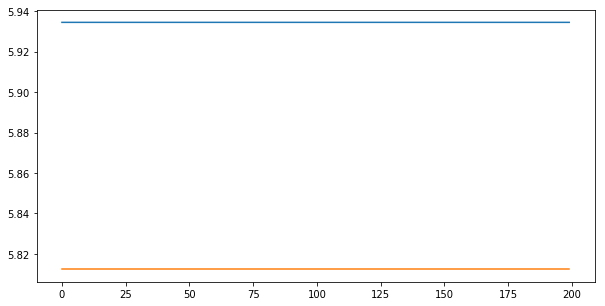

In [17]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

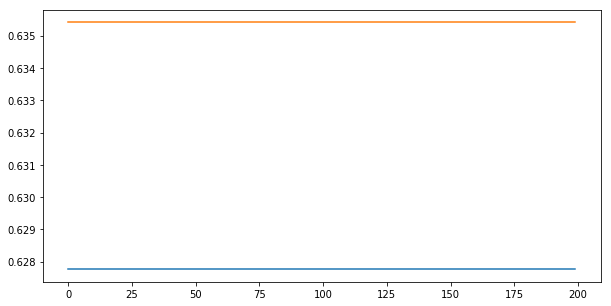

In [18]:
plt.figure(figsize=(10, 5))
# plt.ylim([0,9])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

0.584375
Confusion matrix, without normalization
[[  0 133]
 [  0 187]]


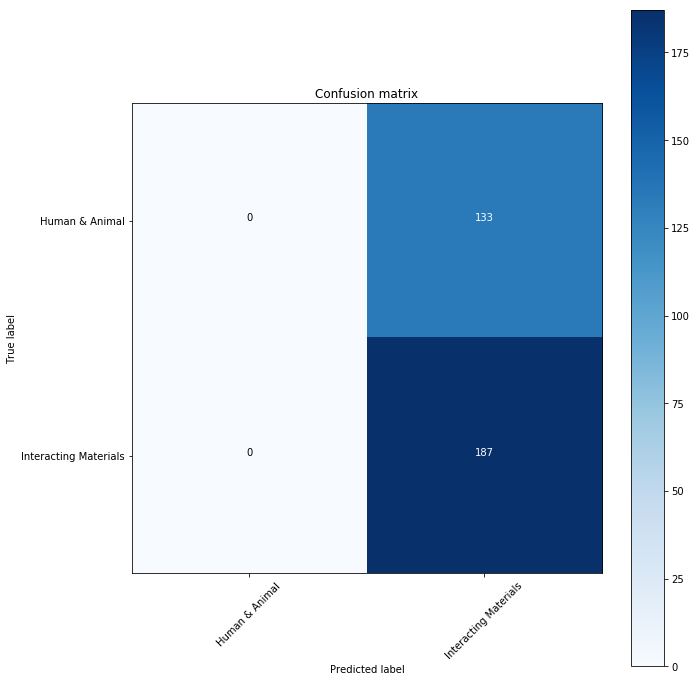

In [19]:
pred = anim.predict(test_X)
print(metrics.accuracy_score(test_y, pred))
cm = metrics.confusion_matrix(test_y, pred)
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, h_classes)
plt.show()

# All Data

In [ ]:
all_df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        fld=1, 
                        blocksize=blocksize, 
                        overlap=overlap)

In [ ]:
X = all_df.drop(['target', 'h_target'], axis=1)
y = all_df['h_target']

In [ ]:
pred = anim.predict(X)
print(metrics.accuracy_score(y, pred))
cm = metrics.confusion_matrix(y, pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, h_classes)
plt.show()